In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from grelu.io.genome import get_genome
import torch
import numpy as np
from datasets import Dataset
import pyBigWig
from enformer_pytorch import Enformer
from enformer_pytorch.data import str_to_one_hot
import enformer_pytorch
from accelerate import Accelerator
from torch.utils.data import DataLoader
from borzoi_pytorch import Borzoi
import pandas as pd
from tangermeme.utils import one_hot_encode
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from enformer_pytorch.finetune import HeadAdapterWrapper
import torch.optim as optim
import grelu.data.preprocess
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_scheduler
import bioframe as bf
from math import log
import wandb

device = "cuda"

assembly = "hg38"
genome = get_genome(assembly)


In [3]:
def load_enformer_model(mixed_precision: str = "bf16", **kwargs) -> Enformer:
    model = enformer_pytorch.from_pretrained("EleutherAI/enformer-official-rough", **kwargs)
    accelerator = Accelerator(mixed_precision=mixed_precision)
    model = accelerator.prepare(model)
    model.eval()
    return model

In [4]:
seq_length = 196_608  
target_length = 896  
bin_size = 128  

def create_interval(seq_length, chromosome):
    length = len(genome[chromosome])
    intervals = []
    for start in range(0, length - seq_length,target_length*bin_size):
        end = min(start + seq_length ,length)
        predic_start = start + bin_size*320
        predic_end = end - 320*bin_size  
        intervals.append((start, end, predic_start, predic_end))
        
    df = pd.DataFrame(intervals, columns=["start", "end", "predic_start", "predic_end"])
    return df

In [5]:
backbone = load_enformer_model()
model = HeadAdapterWrapper(enformer=backbone, num_tracks=1)
model.to(device)

HeadAdapterWrapper(
  (enformer): Enformer(
    (stem): Sequential(
      (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
        )
      )
      (2): AttentionPool(
        (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
        (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (conv_tower): Sequential(
      (0): Sequential(
        (0): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): Residual(
          (fn): Sequential(
            (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [38]:
train_chroms = 'chr10'
val_chroms = 'chr18'
test_chroms = 'chr12'
chroms = [train_chroms, val_chroms, test_chroms]

In [6]:
train_chroms = []
for i in range(0,10):
    chrom = f"chr{i+1}"
    train_chroms.append(chrom)
print(train_chroms)
val_chroms = 'chr15'
chroms = train_chroms + [val_chroms]
print(chroms)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10']
['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr15']


In [7]:

import pyfaidx

def get_n_intervals(genome, chroms, min_n_count=10):
    n_intervals = []

    for chrom in chroms:
        seq = str(genome[chrom])
        starts = np.where(np.array(list(seq)) == 'N')[0]

        if len(starts) == 0:
            continue

        diffs = np.diff(starts)
        split_points = np.where(diffs > 1)[0] + 1
        intervals = np.split(starts, split_points)

        intervals = [(i[0], i[-1] + 1) for i in intervals if len(i) >= min_n_count]
        n_intervals.extend([(chrom, start, end) for start, end in intervals])

    return pd.DataFrame(n_intervals, columns=["chrom", "start", "end"]) if n_intervals else None


def get_defined_intervals(genome,chroms, min_length=None, min_n_count=10):
    chroms = chroms 

    intervals = pd.DataFrame([(chrom, 0, len(genome[chrom])) for chrom in chroms],
                             columns=["chrom", "start", "end"])

    n_intervals = get_n_intervals(genome, chroms, min_n_count)
    if n_intervals is not None:
        intervals = bf.subtract(intervals, n_intervals)

    if min_length:
        intervals = intervals[(intervals.end - intervals.start) > min_length]

    return intervals

In [8]:
interval_df = get_defined_intervals(genome,chroms= chroms, min_n_count=10)

In [42]:
interval_df
df_chr15 = interval_df[interval_df['chrom']== 'chr15']
print(df_chr15)

     chrom     start        end
278  chr15  17000000   17049135
279  chr15  17049334   17083573
280  chr15  17083673   17498951
281  chr15  17499051   17751900
282  chr15  17752000   18341758
283  chr15  18341858   18355008
284  chr15  18355108   18979846
285  chr15  18979946   19725254
286  chr15  19775254   20689304
287  chr15  20729746   21193490
288  chr15  21242090   21778502
289  chr15  21828502   22308242
290  chr15  22358242   23226874
291  chr15  23276874   84270066
292  chr15  84320066  101981189


In [9]:

def create_interval_n(interval_df, seq_length):
    chrom_intervals = {}
    for idx, row in interval_df.iterrows():
        chrom = row["chrom"]
        start = row["start"]
        end = row["end"]
        intervals = []
        for inter_start in range(start, end - seq_length,target_length*bin_size):
            inter_end = min(inter_start + seq_length ,end)
            predic_start = inter_start + bin_size*320
            predic_end = inter_end - 320*bin_size  
            intervals.append((chrom, inter_start, inter_end, predic_start, predic_end))
        new_intervals_df = pd.DataFrame(intervals, columns=["chrom", "start", "end", "predic_start", "predic_end"])
        if chrom in chrom_intervals:
            chrom_intervals[chrom] =pd.concat([chrom_intervals[chrom], new_intervals_df], ignore_index=True)
        else:
            chrom_intervals[chrom] = new_intervals_df
    return chrom_intervals

In [10]:
chrom_inter = create_interval_n(interval_df, seq_length)
chrom_inter

{'chr1':      chrom      start        end predic_start predic_end
 0     chr1      10000     206608        50960     165648
 1     chr1     585988     782596       626948     741636
 2     chr1     700676     897284       741636     856324
 3     chr1     815364    1011972       856324     971012
 4     chr1     930052    1126660       971012    1085700
 ...    ...        ...        ...          ...        ...
 1984  chr1  248220012  248416620    248260972  248375660
 1985  chr1  248334700  248531308    248375660  248490348
 1986  chr1  248449388  248645996    248490348  248605036
 1987  chr1  248564076  248760684    248605036  248719724
 1988  chr1  248678764  248875372    248719724  248834412
 
 [1989 rows x 5 columns],
 'chr2':      chrom      start        end predic_start predic_end
 0     chr2      10000     206608        50960     165648
 1     chr2     124688     321296       165648     280336
 2     chr2     239376     435984       280336     395024
 3     chr2     354064     5

In [12]:
df_train = chrom_inter[train_chroms]
df_val = chrom_inter[val_chroms]
df_train


TypeError: unhashable type: 'list'

In [11]:
inter = []
for i in range(0,10):
    interv = chrom_inter[f"chr{i+1}"]
    inter.append(interv)
df_train = pd.concat(inter, axis=0)
df_val = chrom_inter["chr15"]
df_chr1 = df_train[df_train["chrom"] == "chr1"]
print(df_chr1)

     chrom      start        end predic_start predic_end
0     chr1      10000     206608        50960     165648
1     chr1     585988     782596       626948     741636
2     chr1     700676     897284       741636     856324
3     chr1     815364    1011972       856324     971012
4     chr1     930052    1126660       971012    1085700
...    ...        ...        ...          ...        ...
1984  chr1  248220012  248416620    248260972  248375660
1985  chr1  248334700  248531308    248375660  248490348
1986  chr1  248449388  248645996    248490348  248605036
1987  chr1  248564076  248760684    248605036  248719724
1988  chr1  248678764  248875372    248719724  248834412

[1989 rows x 5 columns]


In [12]:
train_data = df_train
#eval_data = df_val
eval_data = df_val
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(eval_data)}")
train_data

Train data size: 15246
Validation data size: 722


,chrom,start,end,predic_start,predic_end
0,chr1,10000,206608,50960,165648
1,chr1,585988,782596,626948,741636
2,chr1,700676,897284,741636,856324
3,chr1,815364,1011972,856324,971012
4,chr1,930052,1126660,971012,1085700
...,...,...,...,...,...
1139,chr10,132973386,133169994,133014346,133129034
1140,chr10,133088074,133284682,133129034,133243722
1141,chr10,133202762,133399370,133243722,133358410
1142,chr10,133317450,133514058,133358410,133473098


In [13]:

def expression_val_histone(df,bin_size, bw_file):
    bw = pyBigWig.open(bw_file)
    binned_expression_list = []
    chrom_sizes = bw.chroms() 
    max_bins = 0
    for idx, row in df.iterrows():
        start = row['predic_start'] 
        end = row['predic_end']  
        chrom = row["chrom"]
        chrom_length = chrom_sizes[chrom]
        if start >= chrom_length or end <= 0:
            print(f"Warning: {chrom} [{start}, {end}] is out of range.")
            binned_expression_list.append(np.zeros(1, np.float32))
            continue

        start = max(0, start)
        end = min(chrom_length, end)

        expression_values = bw.values(chrom, start, end, numpy=True)
        expression_values = np.nan_to_num(expression_values)

        valid_size = (expression_values.size // bin_size) * bin_size
        if valid_size > 0:
            expression_values = expression_values[:valid_size]  
            binned_expression = expression_values.reshape(-1, bin_size).mean(axis=1)
        else:
            binned_expression = np.array([expression_values.mean()]) 

        max_bins = max(max_bins, len(binned_expression))
        binned_expression_list.append(binned_expression.astype(np.float32))

    bw.close()

    for i in range(len(binned_expression_list)):
        diff = max_bins - len(binned_expression_list[i])
        if diff > 0:
            binned_expression_list[i] = np.pad(binned_expression_list[i], (0, diff), mode='constant', constant_values=0)


    df_binned = pd.DataFrame({'labels': binned_expression_list}, index = df.index)

    return df_binned

In [14]:
bw = "SRR18582971.signal.bl_s8_exz.bw"

train_expression = expression_val_histone(train_data,bin_size=bin_size, bw_file=bw)
train_data.loc[:, 'labels'] = train_expression

val_expression = expression_val_histone(eval_data,bin_size=bin_size, bw_file=bw)
eval_data.loc[:, 'labels'] = val_expression

#test_expression = expression_val_histone(test_data, bin_size=bin_size, chromosome=test_chroms, bw_file=bw)
#test_data.loc[:, 'labels'] = test_expression

eval_data

,chrom,start,end,predic_start,predic_end,labels
0,chr15,17083673,17280281,17124633,17239321,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,chr15,17198361,17394969,17239321,17354009,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,chr15,17499051,17695659,17540011,17654699,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,chr15,17752000,17948608,17792960,17907648,"[17.132324, 16.728577, 26.589783, 60.19922, 45..."
4,chr15,17866688,18063296,17907648,18022336,"[74.56348, 133.8003, 157.83008, 103.691895, 15..."
...,...,...,...,...,...,...
717,chr15,101293890,101490498,101334850,101449538,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
718,chr15,101408578,101605186,101449538,101564226,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
719,chr15,101523266,101719874,101564226,101678914,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
720,chr15,101637954,101834562,101678914,101793602,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [68]:
print(train_expression.shape)
print(train_expression)

(15246, 1)
                                                 labels
0     [0.0, 0.0, 1.734375, 0.296875, 3.96875, 2.1093...
1     [4.421875, 6.46875, 6.28125, 16.640625, 16.140...
2     [3.34375, 2.34375, 3.8359375, 3.640625, 0.0, 3...
3     [0.171875, 2.0, 1.671875, 9.890625, 7.15625, 5...
4     [6.90625, 6.6796875, 3.9765625, 0.0, 0.484375,...
...                                                 ...
1139  [13.046875, 1.265625, 1.90625, 0.0, 0.0, 1.078...
1140  [31.289062, 30.875, 38.015625, 31.734375, 28.3...
1141  [1.75, 1.859375, 5.890625, 10.09375, 3.546875,...
1142  [12.0625, 7.890625, 3.6875, 1.0625, 7.875, 14....
1143  [5.6875, 9.15625, 6.015625, 2.671875, 1.828125...

[15246 rows x 1 columns]


[0.        0.        0.        ... 1.3661844 1.3281289 2.2298126]


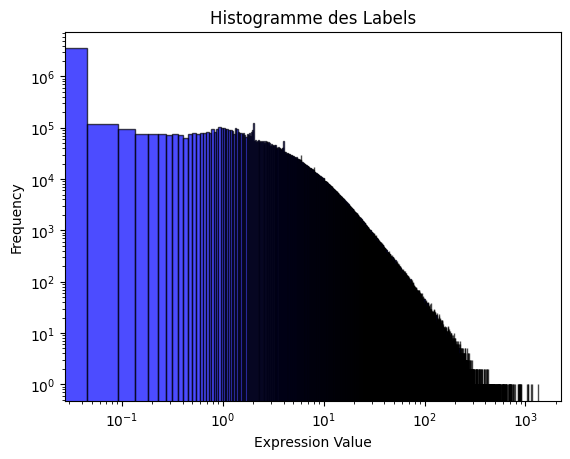

1335.3906


In [51]:

flattened_values = np.concatenate(train_expression["labels"].values)
#flattened_values = np.log(flattened_values + 0.001) 
print(flattened_values)
plt.hist(flattened_values, bins='auto', alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Expression Value")
plt.xscale("log")
plt.yscale("log")
#plt.xlim(0,100)
plt.ylabel("Frequency")
plt.title("Histogramme des Labels")
plt.show()
max = np.max(flattened_values)
print(max)

In [ ]:
bw_map = pyBigWig.open("k36.Umap.MultiTrackMappability.bw")

chrom = "chr1"  
start = 1000000  
end = 1000100    

mappability_values = bw_map.values(chrom, start, end)

print(mappability_values)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [15]:
def get_mapability(df,bin_size, bw_file):
    bw = pyBigWig.open(bw_file)
    mapability_list = []
    chrom_sizes = bw.chroms() 
    max_bins = 0
    for idx, row in df.iterrows():
        start = row['predic_start']  
        end = row['predic_end']  
        chrom = row["chrom"]
        chrom_length = chrom_sizes[chrom]
        
        if start >= chrom_length or end <= 0:
            print(f"Warning: {chrom} [{start}, {end}] is out of range.")
            mapability_list.append(np.zeros(1))
            continue

        start = max(0, start)
        end = min(chrom_length, end)
        
        mapability_values = bw.values(chrom, start, end, numpy=True)
        mapability_values = np.nan_to_num(mapability_values)

        valid_size = (mapability_values.size // bin_size) * bin_size
        if valid_size > 0:
            mapability_values = mapability_values[:valid_size]
            mapability = mapability_values.reshape(-1, bin_size).mean(axis=1)
            mapability = (mapability > 0.9)
        else:
            mapability = [mapability_values.mean()]
            mapability = (mapability > 0.9)

        max_bins = max(max_bins, len(mapability))
        mapability_list.append(mapability)

    bw.close()

    for i in range(len(mapability_list)):
        diff = max_bins - len(mapability_list[i])
        if diff > 0:
            mapability_list[i] = np.pad(mapability_list[i], (False, diff), mode='constant') 


    df_map = pd.DataFrame({'mapability': mapability_list})

    return df_map

In [16]:
bw = "k36.Umap.MultiTrackMappability.bw"

train_map = get_mapability(train_data,bin_size=bin_size, bw_file=bw)
train_data.loc[:, 'map'] = train_map

val_map = get_mapability(eval_data,bin_size=bin_size,  bw_file=bw)
eval_data.loc[:, 'map'] = val_map
train_data


,chrom,start,end,predic_start,predic_end,labels,map
0,chr1,10000,206608,50960,165648,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal..."
1,chr1,585988,782596,626948,741636,"[4.3923645, 6.4981995, 6.288086, 16.6156, 16.0...","[False, False, False, False, False, False, Fal..."
2,chr1,700676,897284,741636,856324,"[3.3362427, 2.3638659, 3.8654022, 3.609385, 0....","[False, False, False, False, False, False, Fal..."
3,chr1,815364,1011972,856324,971012,"[0.17643367, 1.9954453, 1.6724548, 9.889908, 7...","[False, False, False, False, False, False, Fal..."
4,chr1,930052,1126660,971012,1085700,"[6.901184, 6.674652, 3.9589748, 0.017688282, 0...","[True, True, True, True, True, True, True, Tru..."
...,...,...,...,...,...,...,...
1139,chr10,132973386,133169994,133014346,133129034,"[13.002014, 1.3456844, 1.8665469, 0.0, 0.0, 1....","[False, False, True, True, True, True, True, T..."
1140,chr10,133088074,133284682,133129034,133243722,"[31.3479, 30.902832, 37.98291, 31.708008, 28.3...","[False, True, True, True, True, True, True, Tr..."
1141,chr10,133202762,133399370,133243722,133358410,"[1.7279596, 1.8653083, 5.877838, 10.076202, 3....","[False, False, False, False, False, False, Tru..."
1142,chr10,133317450,133514058,133358410,133473098,"[12.062378, 7.9201508, 3.6578674, 1.0626413, 7...","[True, True, True, True, True, True, True, Tru..."


In [19]:
flattened_map = np.concatenate(train_expression["map"].values)

plt.hist(flattened_map, bins='auto', alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Expression Value")
plt.yscale("log")   
plt.ylabel("Frequency")
plt.title("Histogramme des Labels")
plt.show()

KeyError: 'map'

In [19]:
print(train_data['labels'])


0       [9.671875, 7.890625, 6.765625, 1.71875, 21.578...
1       [2.015625, 0.65625, 0.15625, 1.1875, 0.140625,...
2       [0.0, 0.796875, 0.0, 0.84375, 1.4375, 1.0625, ...
3       [4.796875, 7.046875, 4.203125, 2.265625, 2.046...
4       [0.0, 0.0, 0.0, 1.375, 1.875, 7.90625, 1.57812...
                              ...                        
1139    [13.046875, 1.265625, 1.90625, 0.0, 0.0, 1.078...
1140    [31.289062, 30.875, 38.015625, 31.734375, 28.3...
1141    [1.75, 1.859375, 5.890625, 10.09375, 3.546875,...
1142    [12.0625, 7.890625, 3.6875, 1.0625, 7.875, 14....
1143    [5.6875, 9.15625, 6.015625, 2.671875, 1.828125...
Name: labels, Length: 1144, dtype: object


In [17]:

train_ds = Dataset.from_pandas(train_data)
train_ds.set_format("torch")
val_ds = Dataset.from_pandas(eval_data)
val_ds.set_format("torch")
#test_ds = Dataset.from_pandas(test_data)
#test_ds.set_format("torch")



In [18]:
def process_sequences(ds):
    
    return ds.map(
        lambda x: {
            "input_oh": one_hot_encode(
                genome.get_seq(x["chrom"], int(x["start"]) + 1, int(x["end"])).seq.upper(),
            ).to(torch.int8),
            "mask": 1 if any(c.islower() for c in genome.get_seq(x["chrom"], int(x["start"]) + 1, int(x["end"])).seq) else 0
        }
    )

train_ds = process_sequences(train_ds)
val_ds = process_sequences(val_ds)
#test_ds = process_sequences(test_ds, test_chroms)


Map:   0%|          | 0/15246 [00:00<?, ? examples/s]

Map:   0%|          | 0/722 [00:00<?, ? examples/s]

Dataset({
    features: ['chrom', 'start', 'end', 'predic_start', 'predic_end', 'labels', '__index_level_0__', 'input_oh', 'mask'],
    num_rows: 15246
})

In [19]:
train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=4, shuffle=False)
val_ds
#test_dataloader = DataLoader(test_ds, batch_size=2, shuffle=False)


Dataset({
    features: ['chrom', 'start', 'end', 'predic_start', 'predic_end', 'labels', 'map', 'input_oh', 'mask'],
    num_rows: 722
})

In [20]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss() 
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


In [49]:
def poisson_loss(pred, target, weights=None):
    """Poisson loss a la Enformer"""
    p = pred - target * torch.log(pred)
    if weights is not None:
        loss = (p * weights).sum() / weights.sum()
    else:
        loss = p.mean()
    #
    return loss

In [ ]:

def evaluate_model(model, val_dataloader):
    model.eval()  
    all_preds = []
    all_labels = []
    total_val_loss = 0  
    total_mse = []
    total_pearson = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            sequences = batch["input_oh"]
            labels = batch["labels"].to(device)
            mapability = batch["map"].to(device)
            sequences = sequences.permute(0, 2, 1).to(device).to(dtype=torch.float16)

            predictions = model(sequences)

            mask = (labels >= 0.01)
            mask_map = mapability.bool()
            valid_indices = mask & mask_map

            filtered_preds = predictions[valid_indices]
            filtered_labels = labels[valid_indices]

            if filtered_preds.numel() == 0 or filtered_labels.numel() == 0:
                continue  

            filtered_preds = filtered_preds.reshape(-1)
            filtered_labels = filtered_labels.reshape(-1)

            loss = loss_fn(filtered_preds, filtered_labels)
            total_val_loss += loss.item()

            labels_np = filtered_labels.cpu().numpy()
            preds_np = filtered_preds.cpu().numpy()

            if preds_np.size > 0 and labels_np.size > 0:
                mse = mean_squared_error(labels_np, preds_np)
                total_mse.append(mse)

                if np.std(labels_np) > 0 and np.std(preds_np) > 0:
                    pearson_corr = np.corrcoef(labels_np, preds_np)[0, 1]
                else:
                    pearson_corr = 0  

                total_pearson.append(pearson_corr)

                all_preds.extend(preds_np)
                all_labels.extend(labels_np)

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_mse = np.mean(total_mse) if total_mse else float('nan')
    avg_pearson = np.mean(total_pearson) if total_pearson else float('nan')

    return avg_mse, avg_pearson, avg_val_loss

In [27]:

def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs):
    progress_bar = tqdm(range(num_epochs * len(train_dataloader)))
    #wandb.init(project="nom_du_projet", name="nom_du_run", config={"epochs": num_epochs, "batch_size": len(train_dataloader)})

    train_losses = []
    val_losses = []
    val_rmses = []
    val_pearsons = []
    step = 0

    for epoch in range(num_epochs):
        model.train()  
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            sequences = batch["input_oh"]
            labels = batch["labels"].to(device)
            mapability = batch["map"].to(device)
            sequences = sequences.permute(0, 2, 1).to(device).to(dtype=torch.float16)

            predictions = model(sequences)
            mask_map = mapability.bool()            
            mask = (labels >= 0.01)  

            filtered_predictions = predictions[mask & mask_map] 
            filtered_labels = labels[mask & mask_map]
            filtered_predictions = filtered_predictions.squeeze()
            filtered_labels = filtered_labels.squeeze()
           
            loss = loss_fn(filtered_predictions, filtered_labels)
            loss.backward()  
            
            optimizer.step() 

            total_loss += loss.item()
            progress_bar.update(1)
            step +=1
            if step % 300 == 0:
                mse, pearson_corr, val_loss = evaluate_model(model, val_dataloader)
                
                val_losses.append(val_loss)
                val_rmses.append(mse)
                val_pearsons.append(pearson_corr)

                print(f"Step {step}: Validation RMSE: {mse:.4f}, Pearson: {pearson_corr:.4f}, val loss: {val_loss:.4f}")

                #wandb.log({
                #"step": step,
                #"validation_rmse": rmse,
                #"validation_pearson": pearson_corr,
                #"validation_loss": val_loss
            #})

        avg_loss = total_loss / len(train_dataloader)
        #wandb.log({
        #"epoch": epoch + 1,
        #"training_loss": avg_loss
    #})
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_loss:.4f}")

    wandb.finish()
    return train_losses, val_losses, val_rmses, val_pearsons

train_losses, val_losses, val_rmses, val_pearsons= train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=5)  

  0%|          | 0/38115 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/7623 [00:00<?, ?it/s]

Validation:   0%|          | 0/181 [00:00<?, ?it/s]

TypeError: Input should have at least 1 dimension i.e. satisfy `len(x.shape) > 0`, got scalar `array(27.572754, dtype=float32)` instead.

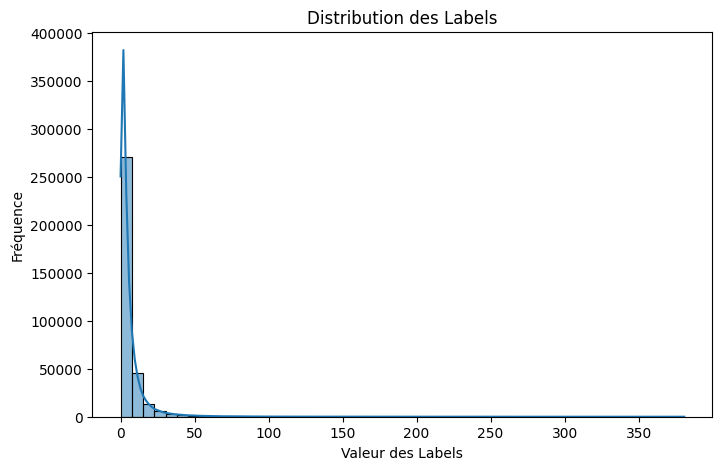

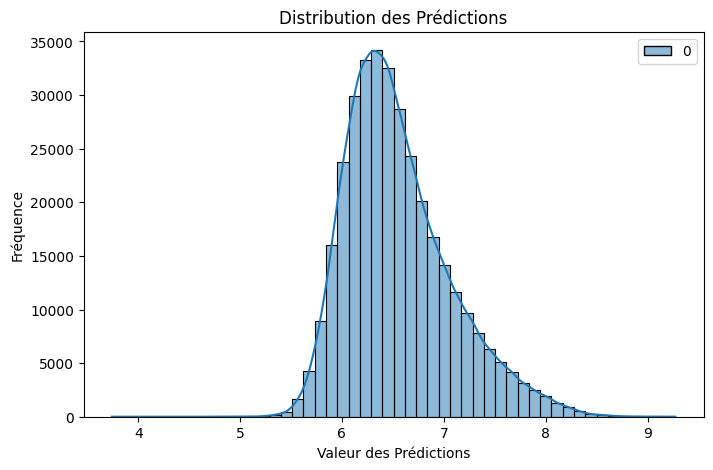

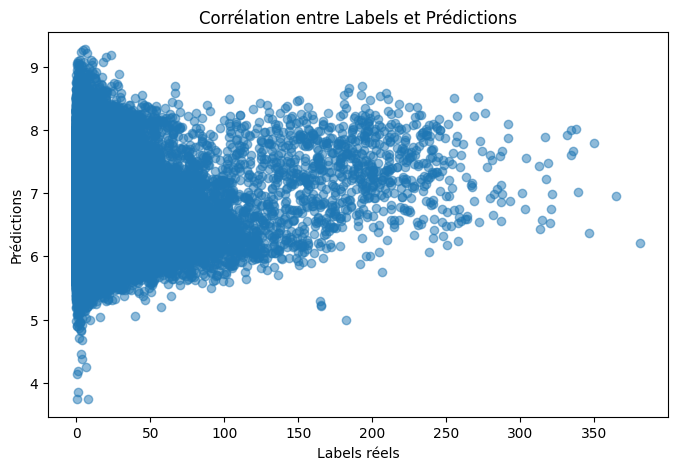

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 344754 and the array at index 1 has size 1

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score


def get_predictions_and_labels(model, val_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            sequences = batch["input_oh"]
            labels = batch["labels"].to(device)
            mapability = batch["map"].to(device)
            sequences = sequences.permute(0, 2, 1).to(device).to(dtype=torch.float16)

            predictions = model(sequences)

            mask = (labels >= 0.01)
            mask_map = mapability.bool()
            filtered_preds = predictions[mask & mask_map]
            filtered_labels = labels[mask & mask_map]

            if filtered_preds.numel() > 0 and filtered_labels.numel() > 0:
                all_preds.extend(filtered_preds.cpu().numpy())
                all_labels.extend(filtered_labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

preds, labels = get_predictions_and_labels(model, val_dataloader)

plt.figure(figsize=(8, 5))
sns.histplot(labels, bins=50, kde=True)
plt.title("Distribution des Labels")
plt.xlabel("Valeur des Labels")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(preds, bins=50, kde=True)
plt.title("Distribution des Prédictions")
plt.xlabel("Valeur des Prédictions")
plt.ylabel("Fréquence")
plt.show()



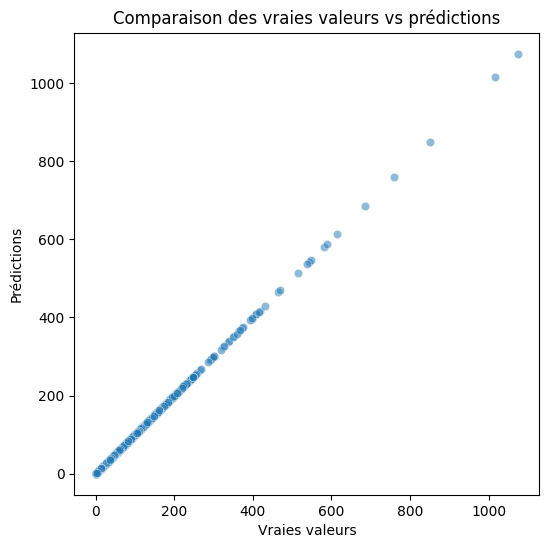

In [ ]:
import seaborn as sns

y_true_ = np.array(y_true).flatten()
y_pred_ = np.array(y_pred).flatten()

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true_, y=y_pred_, alpha=0.5)
plt.xlabel("Vraies valeurs")
plt.ylabel("Prédictions")
plt.title("Comparaison des vraies valeurs vs prédictions")
plt.show()

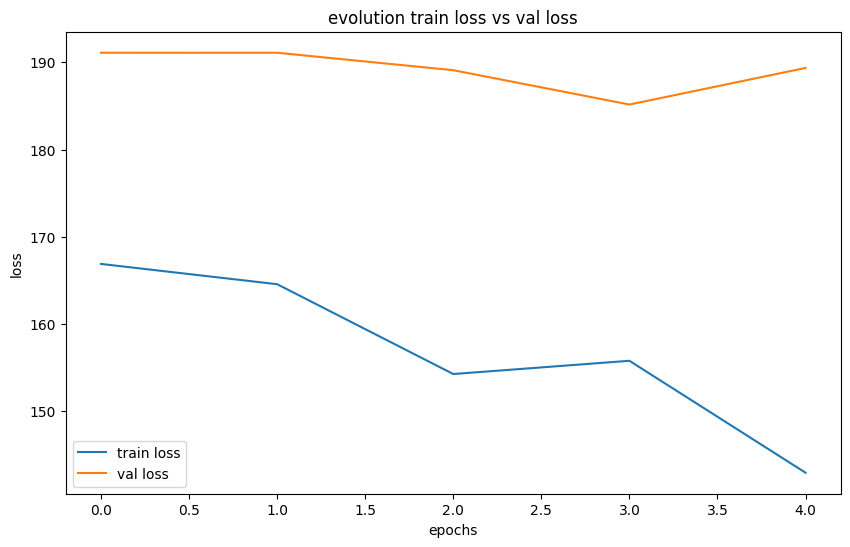

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses , label = "val loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("evolution train loss vs val loss")
plt.show()

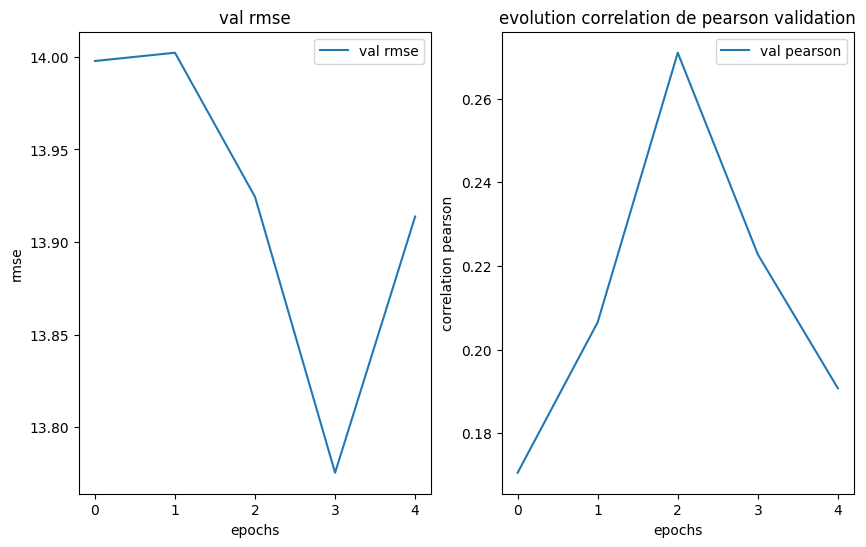

In [30]:
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plt.plot(val_rmses , label = "val rmse")
plt.xlabel("epochs")
plt.ylabel("rmse")
plt.legend()
plt.title("val rmse")

plt.subplot(1,2,2)
plt.plot(val_pearsons, label = "val pearson")
plt.xlabel("epochs")
plt.ylabel("correlation pearson")
plt.legend()
plt.title("evolution correlation de pearson validation")

plt.show()

flashzoi

In [ ]:
def load_flashzoi_model(mixed_precision: str = "bf16", **kwargs):
    model = Borzoi.from_pretrained('johahi/flashzoi-replicate-0') # 'johahi/flashzoi-replicate-[0-3]'
    accelerator = Accelerator(mixed_precision=mixed_precision)
    model = accelerator.prepare(model)
    model.eval()
    return model

In [ ]:
backbone = load_enformer_model()
model_flashzoi = HeadAdapterWrapper(enformer=backbone, num_tracks=1)
model_flashzoi.to(device)

In [ ]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = optim.AdamW(model_flashzoi.parameters(), lr=1e-4)
loss_fn = nn.MSELoss() 
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


In [ ]:
def evaluate_model_flashzoi(model, val_dataloader):
    model.eval() 
    all_preds = []
    all_labels = []
    total_val_loss = 0  

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            sequences = batch["input_oh"]
            labels = batch["labels"].to(device)
            mapability = batch["map"].to(device)
            sequences = sequences.permute(0, 2, 1).to(device).to(dtype=torch.float16)
            predictions = model(sequences)

            mask = (labels > 0.1)
            mask_map = (mapability is True)

            filtered_preds = predictions[mask & mask_map]
            filtered_preds = filtered_preds.squeeze()

            filtered_labels = labels[mask & mask_map]
            filtered_labels = filtered_labels.squeeze()
            if len(filtered_preds) > 0:
                loss = loss_fn(filtered_preds, filtered_labels)
                total_val_loss += loss.item()

            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    assert len(all_preds) == len(all_labels), f"Mismatch in number of batches: {len(all_preds)} != {len(all_labels)}"


    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_labels = all_labels.flatten() 
    #all_preds = all_preds.flatten()

    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)
    rmse = np.sqrt(mse)
    pearson_corr = np.corrcoef(all_preds, all_labels)[0, 1]
    
    return mae, rmse, pearson_corr, avg_val_loss, all_preds, all_labels

In [ ]:
def train_model_flashzoi(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs):
    progress_bar = tqdm(range(num_epochs * len(train_dataloader)))
    wandb.init(project="nom_du_projet", name="nom_du_run", config={"epochs": num_epochs, "batch_size": len(train_dataloader)})

    train_losses = []
    val_losses = []
    val_rmses = []
    val_pearsons = []
    step = 0

    for epoch in range(num_epochs):
        model.train()  
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            sequences = batch["input_oh"]
            labels = batch["labels"].to(device)
            mapability = batch["map"].to(device)
            sequences = sequences.permute(0, 2, 1).to(device).to(dtype=torch.float16)

            predictions = model(sequences)
            mask_map = mapability.bool()            
            mask = (labels >= 0.1)  

            filtered_predictions = predictions[mask & mask_map] 
            filtered_labels = labels[mask & mask_map]
            filtered_predictions = filtered_predictions.squeeze()
            filtered_labels = filtered_labels.squeeze()
           
            loss = loss_fn(filtered_predictions, filtered_labels)
            loss.backward()  

            optimizer.step() 

            total_loss += loss.item()
            progress_bar.update(1)
            avg_loss = total_loss / len(train_dataloader)
            step +=1
            if step % 250 == 0:
                mae, rmse, pearson_corr, val_loss, y_pred, y_true = evaluate_model(model, val_dataloader)
                
                val_losses.append(val_loss)
                val_rmses.append(rmse)
                val_pearsons.append(pearson_corr)

                print(f"Step {step}: Validation RMSE: {rmse:.4f}, Pearson: {pearson_corr:.4f}, val loss: {val_loss:.4f}")

                wandb.log({
                "step": step,
                "validation_rmse": rmse,
                "validation_pearson": pearson_corr,
                "validation_loss": val_loss
            })

        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        wandb.log({
        "epoch": epoch + 1,
        "training_loss": avg_loss
    })
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_loss:.4f}")

    wandb.finish()
    return train_losses, val_losses, val_rmses, val_pearsons, y_true, y_pred

train_losses, val_losses, val_rmses, val_pearsons, y_true, y_pred = train_model(model_flashzoi, train_dataloader, val_dataloader, optimizer, num_epochs=5)  